# Creating a dataloader and pre-processing our data

## 0. Before we start

This notebook is used to demonstrate how to create a dataloader on a **mock** dataset, which resembles the one, which will be used for the small project in the SUTD 50.039 Deep Learning class (Y2021).

This notebook intends to demonstrate a way to create dataloaders from scratch, i.e. just a folder containing several images, so that it can later be fed into our PyTorch model.

It consists of four parts:

1. Getting familiar with the demo dataset and the images it contains.
2. Creating a dataset object in general, and later, specific ones for training, testing and validation datasets.7
3. Using torch to transform said dataset into a dataloader,
4. and later use the said DataLoader in the training of a simple PyTorch model.

It relies on the following libraries:
- Matplotlib for displaying images in matplotlib plots,
- Numpy for numerical operations on tensors/arrays,
- Pillow (PIL) for opening images,
- and torch/torchvision for typical operations on tensors, datasets and dataloaders.

In [12]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

dataset_dir = './dataset'

## 2. Creating a Dataset object

### 2.a. Creating a global Dataset object

Let us start this part by creating a general Dataset object, called Lung_Dataset.

It starts with of a constructor, which simply gathers the key parameters we listed in Part 1., into attributes of the object.

Second, a describe method is provided, which simply displays a few details regarding the dataset. Note that a describe function like this one is often considered good practice, as it provides any developer with details about the dataset, at a glance.

Third, an open_image method is provided, an will open the image defined by the combination of parameters defined in (group_val, class_val, index_val). For instance, if group_val is set to 'train', class val is set to 'normal' and index_val set to 3, the function will load the image in ./dataset_demo/train/normal/3.jpg.
Note that the open_image method has a few asserts designed to cover for unexpected values for (group_val, class_val, index_val).

Finally, it contains a show_img method, which will open the image for the parameters in (group_val, class_val, index_val), and will display it on screen, using matplotlib.

Our full general Dataset object, Lung_Dataset, is shown below. Note that it inherits from the Dataset class from the torch.utils.data library.

### 2.b. Creating a train Dataset object

In practice however, one likes to define several datasets, for each subgroup (train, test, validation). This class however, will only be used to load images from the ./dataset_demo/train/ folder. It woks roughly as the previous Lung_Dataset class. In practice, we could have inherited Lung_Train_Dataset from Lung_Dataset, but we normally do not bother creating a general Dataset object like Lung_Dataset in Section 2.a.

The Lung_Train_Dataset object resembles to the Lung_Dataset as it contains restricted versions of the same attributes we had in the Lung_Dataset object.

It however contains two additional (special methods), which need to be defined if we want to transform our Lung_Train_Dataset object into a dataloader later on.

The first method is the special length method ( __ len __ ), which should return the number of images present in the dataset. Lucky for us, it can be easily computed using the dataset_numbers attribute of our object.

The second one is the special getitem method ( __ getitem __ ), which is used to fetch an image and its label, using a single index value.

By convention here, we have decided to open the image in ./dataset_demo/train/normal/XXX.jpg, if the value in XXX is strictly lower than 36, which is the number of images in the ./dataset_demo/train/normal/ folder.

Otherwise, we open the image in ./dataset_demo/train/infected/YYY.jpg, where YYY is simply defined as YYY = XXX - 36.

Note that if the value in XXX is larger than the length of the dataset, i.e. 36 + 34 = 70, then no image will be opened and the getitem will display an error, based on the asserts we have in the open_img method.

Finally, the getitem method will return the image, along with a one-hot vector corresponding to the class of the object, i.e. [1, 0] for normal class and [0, 1] for infected class. Both returned parameters will be torch tensors.

In [13]:
class Lung_Train_Dataset(Dataset):
    
    def __init__(self, img_dir, transform=None):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        self.dataset_type = 'train'
        self.transform = transform
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
         # There will be two types of classifications
        # infected classification: normal and infected
        # covid classification (only done on classified infected): non-covid and covid
        # self.classes = {0: 'normal', 1: 'infected'}
        self.infected_classes = {0: 'normal', 1: 'infected'}
        self.covid_classes = {0: 'non-covid', 1: 'covid'}
        self.classes = {0: 'normal', 1: 'non-covid', 2: 'covid'}
        
        # The dataset has been split in training, testing and validation datasets
        self.groups = 'train'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'train_normal': 1341,
                                'train_non-covid': 2530,
                                'train_covid': 1345,
                                }
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'train_normal': f'{img_dir}/train/normal/',
                              'train_non-covid': f'{img_dir}/train/infected/non-covid/',
                              'train_covid': f'{img_dir}/train/infected/covid/',
                              }
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the training dataset of th Lung Dataset"
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'non-covid' or 'covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)] -1
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        # if class_val == 'normal':
        #     path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        # elif class_val == 'non-covid' or class_val == 'covid':
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            img = Image.open(f)
            if self.transform:
              img = self.transform(img)
            im = np.asarray(img)/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train'.
        - class_val variable should be set to 'normal', 'non-covid' or 'covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its infected_label, and covid_label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        max_num_vals = list(self.dataset_numbers.values())
        max_num_normal = int(max_num_vals[0])
        max_num_noncovid = int(max_num_vals[1])
        if index < max_num_normal:
            class_val = 'normal'
            infected_label = torch.Tensor([1, 0])
            covid_label = torch.Tensor([1, 0])
        elif index < max_num_noncovid+max_num_normal:
            class_val = 'non-covid'
            index = index - max_num_normal
            infected_label = torch.Tensor([0, 1])
            covid_label = torch.Tensor([1, 0])
        else:
            class_val = 'covid'
            index = index - max_num_noncovid - max_num_normal
            infected_label = torch.Tensor([0, 1])
            covid_label = torch.Tensor([0, 1])

        im = self.open_img(self.groups, class_val, index)
        
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, infected_label, covid_label


We can then create our Dataset object as before and display a description of the dataset.

## 3. Creating a Dataloader object

The final step is to create Dataloaders, based on our previous Dataset objects. These Dataloaders will later be used for training, testing and evaluating our models in PyTorch.

the dataloaders can be simply created by using the DataLoader object from the torch.utils.data library, and by simply passing it our Dataset object. Additional parameters such as the batch_size (set to 4 for demo here) can be specified. Another interesting parameter is the shuffle = True one, which will randomly shuffle the order in which the images are selected in the Dataset.

Additional parameters for the DataLoader can be specified (see https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader for details), but it will not be necessary for this small project.

In [14]:
ld_train = Lung_Train_Dataset(dataset_dir)
train_loader = DataLoader(ld_train, batch_size = 4, shuffle = True)
print(train_loader)

During the training, you will call for minibatches using a for loop of some sort, probably similar to the one below.

Notice how each iteration of the for loop below produces a torch tensor of size [1, bs_val, 150, 150] in v[0] containing the bs_val = 4 images in the current mini-batch. You also have a torch tensor of size [bs_val, 2], containing the one hot vectors for each of the bs_val = 4 images.

We voluntarily interrupt it after one iteration of the minibatch using an assert False.

In [15]:
# Typical mini-batch for loop on dataloader (train)
for k, v in enumerate(DataLoader(ld_train, batch_size = 4, shuffle = True)):
    print("-----")
    print(k)
    print(v[0])
    print(v[1])
    # Forced stop
    assert False, "Forced stop after one iteration of the for loop"

-----
0
tensor([[[[0.0039, 0.0471, 0.0784,  ..., 0.0000, 0.0000, 0.0078],
          [0.0235, 0.0000, 0.0353,  ..., 0.0000, 0.0000, 0.0039],
          [0.0118, 0.0196, 0.0667,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0157, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0118, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0078]]],


        [[[0.3686, 0.3686, 0.3686,  ..., 0.4196, 0.4118, 0.4078],
          [0.3686, 0.3686, 0.3686,  ..., 0.4196, 0.4118, 0.4078],
          [0.3725, 0.3725, 0.3725,  ..., 0.4196, 0.4118, 0.4078],
          ...,
          [0.1255, 0.1922, 0.1961,  ..., 0.3490, 0.2941, 0.2549],
          [0.1333, 0.2000, 0.1961,  ..., 0.3490, 0.2980, 0.2627],
          [0.1412, 0.2039, 0.2000,  ..., 0.3569, 0.3137, 0.2824]]],


        [[[0.1843, 0.1882, 0.2000,  ..., 0.1529, 0.1176, 0.1490],
          [0.1765, 0.1765, 0.1961,  ..., 0.1608, 0.1216, 0.1490],
          [0.1725, 0.1686, 0.1

AssertionError: Forced stop after one iteration of the for loop

## 4. Using our dataloader for training a model

We can then use our custom dataloader for training a model.
If we decide to create a model as a subclass of the nn.Module of PyTorch, and later write a train function, as in this Notebook shown in class (https://colab.research.google.com/drive/1zhDmMfSFBy3clH-NRp9nXruQXnckZ3X1#scrollTo=KZd049wKyFT8), then our train_loader object defined in Section 3., can be directly fed to our train function in place of the train_loader.

We could for instance, define a simple (probably too simple!) model below.

In [16]:
# A simple mode
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv2D: 1 input channel, 8 output channels, 3 by 3 kernel, stride of 1.
        self.conv1 = nn.Conv2d(1, 4, 3, 1)
        self.fc1 = nn.Linear(87616, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        output = F.log_softmax(x, dim = 1)
        return output

In [17]:
# Create model
model = Net()

Later on, we will probably have to write a train function, which will implement a mini-batch loop, which resembles the one below. It will simply iterate on the DataLoader we have defined earlier.

## \[NOTE\] 
There are 3 values that we will get out of the DataLoader as shown below: `images_data`, `target_infected_labels`, and `target_covid_labels` because of how I altered `__getitem__` in the Custom Dataset to return two labels instead of normal datasets usually returning one. 

In [18]:
# Try model on one mini-batch
for batch_idx, (images_data, target_infected_labels, target_covid_labels) in enumerate(DataLoader(ld_train, batch_size = 4, shuffle = True)):
    predicted_labels = model(images_data)
    print(predicted_labels)
    print(target_infected_labels)
    print(target_covid_labels)
    assert False, "Forced stop after one iteration of the mini-batch for loop"

tensor([[-0.5840, -0.8157],
        [-0.5778, -0.8235],
        [-0.5456, -0.8663],
        [-0.5546, -0.8540]], grad_fn=<LogSoftmaxBackward>)
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])
tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])


AssertionError: Forced stop after one iteration of the mini-batch for loop

## 5. What is next?

You will have to download the full pictures repository, as specified in the Small Project instruction PDF. It will contain a much larger dataset, for which you will have to write a DataLoader. You may reuse parts of the codes presented in this notebook to come up with your custom DataLoader, if necessary.

Later on, you will have to train a model for classification, as suggested in the Small Project PDF!
Good luck!

# hihithisisme

## On transforming

How I made the transforms in this custom Dataset work is to pass it into the dataset's constructors as transform. You can see the snippets below as examples. 


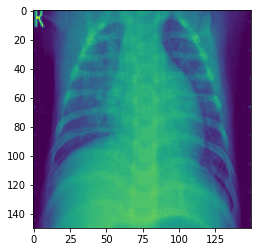

In [19]:
dataset_dir = './dataset'

ld_train = Lung_Train_Dataset(dataset_dir)
ld_train.show_img('train', 'covid', 2)

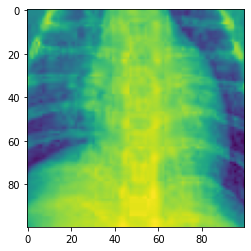

In [21]:
ld_train = Lung_Train_Dataset(dataset_dir, transform=transforms.Compose([
    transforms.CenterCrop(100)
]))
ld_train.show_img('train', 'covid', 2)


In [23]:
from model import train
train(ld_train,epochs = 1)

PreliminaryModel(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
  (relu_1): ReLU()
  (relu_2): ReLU()
  (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=87616, out_features=2, bias=True)
)


NameError: name 'images' is not defined